<a href="https://colab.research.google.com/github/jamissonfreitas/IN1167/blob/master/report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import io
import requests
# lib to plot the data
import matplotlib.pyplot as plt
# lib to use the decompositio in the time series
from statsmodels.tsa.seasonal import seasonal_decompose
# lib to use the acf and pcf correlations
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# lib to organize the data in data frame
from pandas import DataFrame
# lib to organize the time series by periods
from pandas import TimeGrouper

# lib to import the stocastic basic models
from statsmodels.tsa.api import Holt
# lib to import the ar model
from statsmodels.tsa.ar_model import AR

from statsmodels.tsa.arima_model import ARMA, ARIMA

!pip install arch

# Constants

In [0]:
H = 6
V = 12

# Monthly Sunspots

This dataset describes a monthly count of the number of observed sunspots for just over 230 years (1749-1983).

The units are a count and there are 2,820 observations. The source of the dataset is credited to Andrews & Herzberg (1985)

## Data

In [3]:
url='https://raw.githubusercontent.com/jamissonfreitas/IN1167/master/monthly-sunspots.csv'
data = requests.get(url).content
data = data.decode('utf-8').replace("\"","").split('\n')
data = [d.strip().split(',') for d in data][1:-1]
data[:5]

[['1749-01', '58.0'],
 ['1749-02', '62.6'],
 ['1749-03', '70.0'],
 ['1749-04', '55.7'],
 ['1749-05', '85.0']]

In [4]:
df = pd.DataFrame(
    data, 
    columns=['Month', 'Sunspots']
) 
df['Month'] = pd.to_datetime(df['Month'], format='%Y-%m', errors='coerce')
df = df.set_index(df['Month'])
serie = df['Sunspots']
serie[:10]

Month
1749-01-01    58.0
1749-02-01    62.6
1749-03-01    70.0
1749-04-01    55.7
1749-05-01    85.0
1749-06-01    83.5
1749-07-01    94.8
1749-08-01    66.3
1749-09-01    75.9
1749-10-01    75.5
Name: Sunspots, dtype: object

## Plot Serie

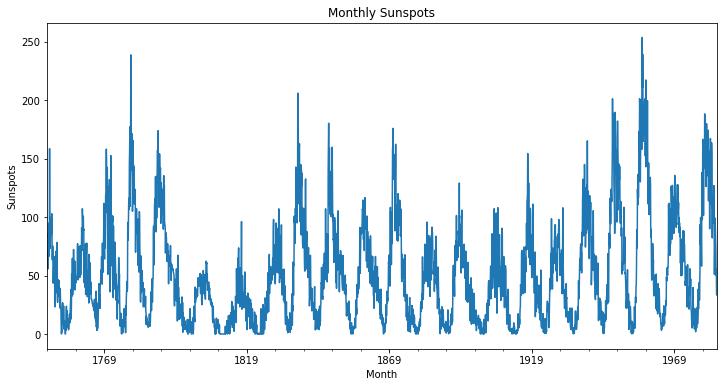

In [5]:
serie = serie.astype(float)
serie.plot(figsize=(V,H))
plt.title('Monthly Sunspots')
plt.ylabel('Sunspots')
plt.xlabel('Month')
plt.show()

### Diff

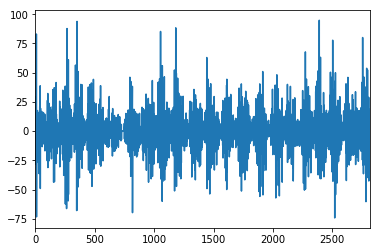

In [6]:
import numpy as np
s_diff = np.diff(serie)
s_diff = pd.Series(s_diff)
s_diff.plot()

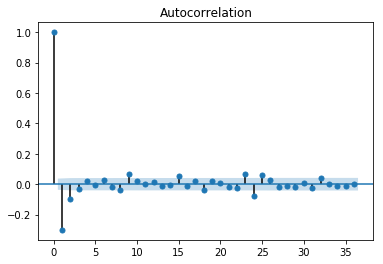

In [23]:
plot_acf(s_diff, lags=36)
plt.show()

## ACF

<Figure size 432x864 with 0 Axes>

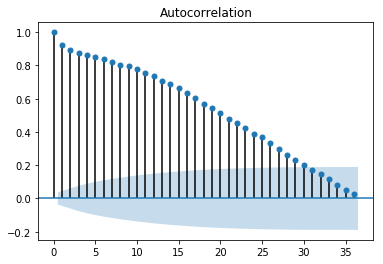

In [7]:
plt.figure(figsize=(H,V))
plot_acf(serie, lags=36)
plt.show()

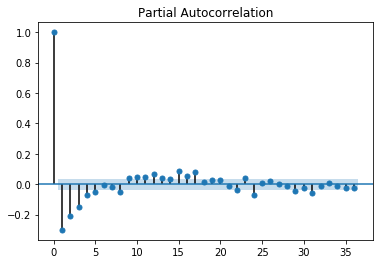

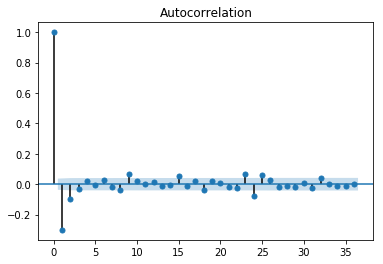

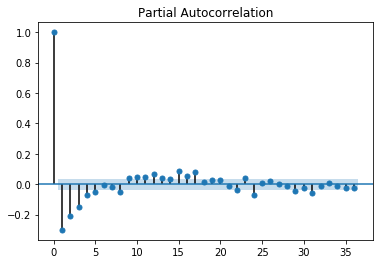

In [8]:
plot_acf(s_diff, lags=36)

plot_pacf(s_diff, lags=36)

## PACF

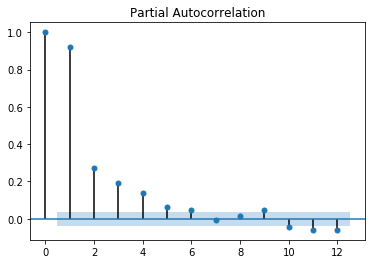

In [9]:
plot_pacf(serie, lags=12)
plt.show()

## Seasonal decompose

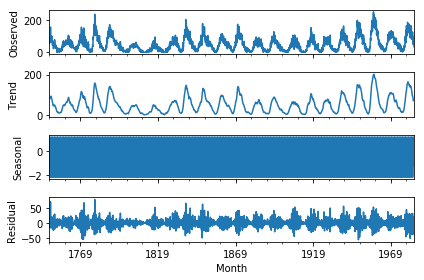

In [10]:
decompose = seasonal_decompose(serie, model='additive')
decompose.plot()
plt.show()

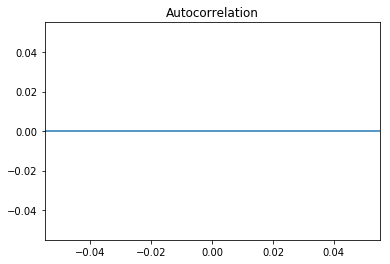

In [11]:
plot_acf(decompose.resid, lags=36)
plt.show()

## Data train and test

In [122]:
size = len(serie)
print(size)
l = int((7*size)/10)
print(l)

# original serie
serie_train = serie[:l]
serie_test = serie[l:]

size = len(s_diff)
print(size)
l = int((7*size)/10)
print(l)

# diff serie
s_diff_train = s_diff[:l]
s_diff_test = s_diff[l:]

300
210
2819
1973


## Models

### Holt-Winters

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


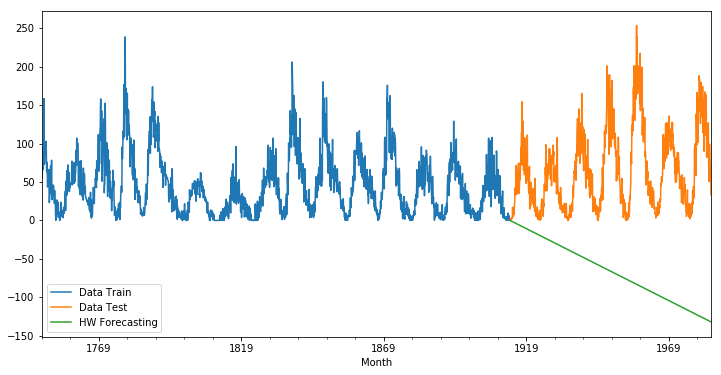

In [13]:
plt.figure(figsize=(V,H))

# fit the data
hw = Holt(serie_train).fit(smoothing_level=0.8, smoothing_slope=0.9)

# original serie
serie_train.plot(label='Data Train')

# original serie
serie_test.plot(label='Data Test')

# plot the data
# hw.fittedvalues.plot(label='HW Fit')

# predict
predict = hw.predict(start=serie_test.index[0], end=serie_test.index[-1])
predict.plot(label='HW Forecasting')

# to show the plot
# hw.forecast(25).rename('HW Forecasting').plot()
plt.legend()
plt.show()

In [14]:
from sklearn.metrics import mean_squared_error

print('MSE = ', mean_squared_error(serie_test, predict))

MSE =  22608.15671122743


### AR

In [15]:
# train AR
model = AR(serie_train)
model_fitted = model.fit(maxlag=6)

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

lags used:  6
parameters:  const          1.709240
L1.Sunspots    0.540106
L2.Sunspots    0.139401
L3.Sunspots    0.068541
L4.Sunspots    0.088893
L5.Sunspots    0.057264
L6.Sunspots    0.066042
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


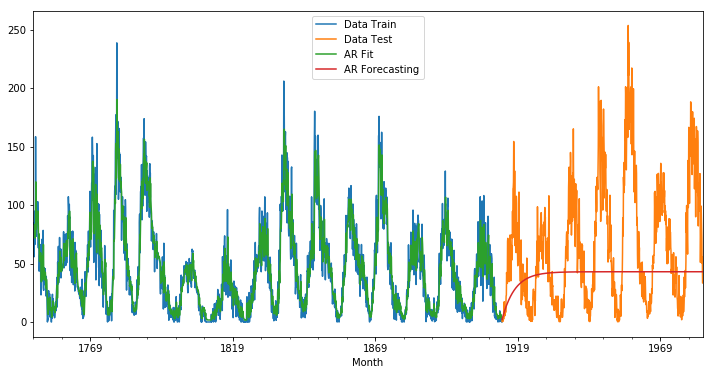

In [16]:
plt.figure(figsize=(V,H))

# plot data train and test
serie_train.plot(label='Data Train')

serie_test.plot(label='Data Test')

predict = model_fitted.predict(start=model_fitted.k_ar, end=len(serie_train), dynamic=False)
predict.plot(label='AR Fit')

predict = model_fitted.predict(start=serie_test.index[0], end=serie_test.index[-1], dynamic=False)
predict.plot(label='AR Forecasting')

#to show
plt.legend()
plt.show()

In [17]:
print('MSE = ', mean_squared_error(serie_test, predict))

MSE =  3206.260633627906


### ARMA

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


lags used:  6
parameters:  const             44.412982
ar.L1.Sunspots     0.033160
ar.L2.Sunspots     0.830982
ar.L3.Sunspots    -0.086852
ar.L4.Sunspots     0.061942
ar.L5.Sunspots     0.092649
ar.L6.Sunspots     0.024687
ma.L1.Sunspots     0.507419
ma.L2.Sunspots    -0.417198
dtype: float64


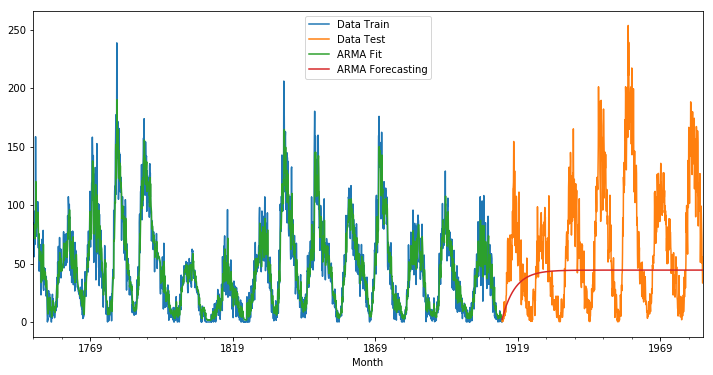

In [25]:
# train ARMA
model = ARMA(serie_train, order=(6, 2))
model_fitted = model.fit()

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

plt.figure(figsize=(V,H))

# plot data train and test
serie_train.plot(label='Data Train')

serie_test.plot(label='Data Test')

predict = model_fitted.predict(start=model_fitted.k_ar, end=len(serie_train), dynamic=False)
predict.plot(label='ARMA Fit')

predict = model_fitted.predict(start=serie_test.index[0], end=serie_test.index[-1], dynamic=False)
predict.plot(label='ARMA Forecasting')

#to show
plt.legend()
plt.show()

In [19]:
print('MSE = ', mean_squared_error(serie_test, predict))

MSE =  3140.5112238081633


### ARIMA

In [80]:
# train ARIMA
model = ARIMA(serie_train, order=(4, 0, 2))
model_fitted = model.fit()

# parameters used
print("lags used: ", model_fitted.k_ar)
print("parameters: ", model_fitted.params)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/tsatools.py:669: RuntimeWarning: invalid value encountered in true_divide
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()


lags used:  4
parameters:  const             44.742878
ar.L1.Sunspots     2.295301
ar.L2.Sunspots    -1.601405
ar.L3.Sunspots     0.285048
ar.L4.Sunspots     0.019105
ma.L1.Sunspots    -1.793756
ma.L2.Sunspots     0.817711
dtype: float64


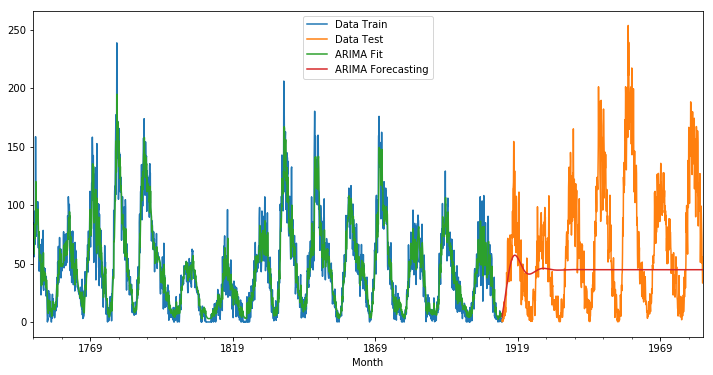

aic: 16232.89133
MSE =  3008.5003930249536


In [81]:
plt.figure(figsize=(V,H))

# plot data train and test
serie_train.plot(label='Data Train')

serie_test.plot(label='Data Test')

predict = model_fitted.predict(start=model_fitted.k_ar, end=len(serie_train), dynamic=False)
predict.plot(label='ARIMA Fit')

predict = model_fitted.predict(start=serie_test.index[0], end=serie_test.index[-1], dynamic=False)
predict.plot(label='ARIMA Forecasting')

#to show
plt.legend()
plt.show()

print('aic: {:6.5f}'.format(model_fitted.aic))

print('MSE = ', mean_squared_error(serie_test, predict))

aic: 16264.03758 | order: (4, 0, 2)


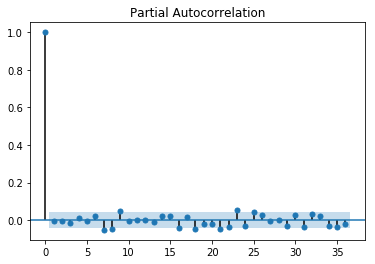

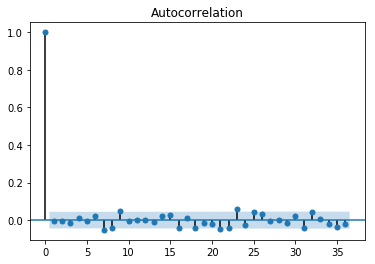

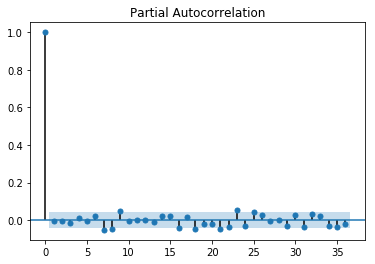

In [82]:
print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

# ARIMA model resid plot
plot_acf(best_mdl.resid, lags=36)

plot_pacf(best_mdl.resid, lags=36)

### GARCH

In [92]:
from arch import arch_model

am = arch_model(s_diff, mean='Zero', vol='GARCH')
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      5,   Neg. LLF: 11587.939362887482
Iteration:      2,   Func. Count:     11,   Neg. LLF: 11582.048419246566
Iteration:      3,   Func. Count:     17,   Neg. LLF: 11581.41426323458
Iteration:      4,   Func. Count:     22,   Neg. LLF: 11577.643016470527
Iteration:      5,   Func. Count:     28,   Neg. LLF: 11577.345148158005
Iteration:      6,   Func. Count:     33,   Neg. LLF: 11577.337867234983
Iteration:      7,   Func. Count:     38,   Neg. LLF: 11577.337216056098
Iteration:      8,   Func. Count:     43,   Neg. LLF: 11577.337213990395
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 11577.337215573993
            Iterations: 8
            Function evaluations: 43
            Gradient evaluations: 8
                       Zero Mean - GARCH Model Results                        
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squ

In [93]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(s_diff, mean='Zero', vol='GARCH', p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                          Zero Mean - GARCH Model Results                           
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                       Zero Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -11496.3
Distribution:      Standardized Student's t   AIC:                           23008.6
Method:                  Maximum Likelihood   BIC:                           23056.1
                                              No. Observations:                 2819
Date:                      Fri, Sep 27 2019   Df Residuals:                     2811
Time:                              01:18:02   Df Model:                            8
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
o

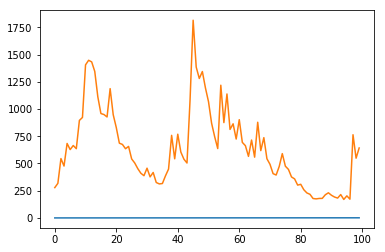

In [95]:
n_test = 100

# forecast the test set
yhat = am.forecast(horizon=n_test, method='simulation', simulations=5, params=res.params)

# plot the actual variance
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-n_test:])

# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

<bound method ARCHModelResult.summary of                      Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -8008.77
Distribution:                  Normal   AIC:                           16033.5
Method:            Maximum Likelihood   BIC:                           16078.2
                                        No. Observations:                 1973
Date:                Fri, Sep 27 2019   Df Residuals:                     1965
Time:                        01:34:13   Df Model:                            8
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.0539      0.

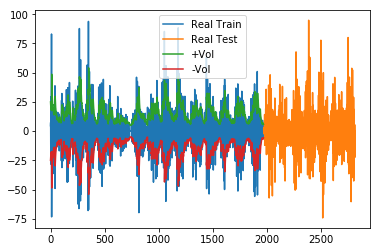

In [123]:
# training a Garch model
garch = arch_model(s_diff_train, vol='GARCH', p=p_, o=o_, q=q_ ).fit( disp='off')

# printing the statisticals
print(garch.summary)

# plotting the modelling
plt.plot(s_diff_train, label='Real Train')
plt.plot(s_diff_test, label='Real Test')
plt.plot(garch._volatility, label = '+Vol')
plt.plot(-garch._volatility, label = '-Vol')
plt.legend(loc='best')
plt.show()

### KALMAN